In [3]:
!pip install langgraph langchain_community langchain_openai

In [1]:
!pip install -U langgraph langchain_openai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 3.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: async-timeout
    Found existing installation: async-timeout 5.0.1
    Uninstalling async-timeout-5.0.1:
      Successfully uninstalled async-timeout-5.0.1
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Unin

# Downloading the sql database for testing the agent


In [22]:
import getpass
import os
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(db_url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)
    print("Database downloaded successfully as Chinook.db")
else:
    print(f"Download failed with status code: {response.status_code}")

Database downloaded successfully as Chinook.db


## Exploring the database

In [23]:
# Initialize database connection
from langchain_community.utilities import SQLDatabase

db_connection = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(f"Database dialect: {db_connection.dialect}")
print(f"Available tables: {db_connection.get_usable_table_names()}")
print(db_connection.run("SELECT * FROM Artist LIMIT 5;"))


Database dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


# Some utility tools

In [24]:
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_robust_tool_node(tools: list) -> RunnableWithFallbacks:
    """Create a tool node with error handling capabilities."""
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(surface_tool_error)], 
        exception_key="error"
    )

def surface_tool_error(state) -> dict:
    """Handle and surface tool errors back to the agent."""
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error encountered: {repr(error)}\nPlease revise your approach.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [25]:
# Create API key handler
from kaggle_secrets import UserSecretsClient
API_KEY = UserSecretsClient().get_secret("OPENAI_API_KEY")

# Defining tools for the agent

We will define a few tools that the agent will use to interact with the database.

    list_tables_tool: Fetch the available tables from the database
    get_schema_tool: Fetch the DDL for a table
    db_query_tool: Execute the query and fetch the results OR return an error message if the query fails


In [26]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI
from kaggle_secrets import UserSecretsClient

toolkit = SQLDatabaseToolkit(
    db=db_connection, 
    llm=ChatOpenAI(model="gpt-4o-mini", api_key=API_KEY)
)
all_tools = toolkit.get_tools()

# Extract specific tools
table_listing_tool = next(tool for tool in all_tools if tool.name == "sql_db_list_tables")
schema_tool = next(tool for tool in all_tools if tool.name == "sql_db_schema")

# Display tool examples
print(table_listing_tool.invoke(""))
print(schema_tool.invoke("Artist"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [27]:
from langchain_core.tools import tool
import hashlib
import json

# Cache dictionary to store query results
query_cache = {}

def generate_cache_key(query: str) -> str:
    """Create a consistent hash key for caching query results."""
    normalized_query = query.strip().lower()
    return hashlib.md5(normalized_query.encode()).hexdigest()


@tool
def database_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and return the results.
    Uses caching to improve performance for repeated queries.
    
    If the query has syntax errors, an error message will be returned.
    """
    # Check cache first
    cache_key = generate_cache_key(query)
    if cache_key in query_cache:
        print("Cache hit! Using cached results.")
        return query_cache[cache_key]
    
    # If not in cache, execute the query
    result = db_connection.run_no_throw(query)
    
    if not result:
        return "Error: Query execution failed. Please revise your SQL syntax."
    
    # Store successful query results in cache
    query_cache[cache_key] = result
    return result

# Check tool functionality
print(database_query_tool.invoke("SELECT * FROM Artist LIMIT 5;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


In [28]:
from langchain_core.tools import tool
import pandas as pd
from typing import Literal

@tool
def format_query_results(query_results: str, format_type: Literal["table", "json", "csv", "markdown"] = "table") -> str:
    """
    Format query results in different presentation styles.
    
    Args:
        query_results: The string results from a database query
        format_type: The desired output format (table, json, csv, markdown)
        
    Returns:
        Formatted query results in the specified format
    """
    try:
        # Convert string results to DataFrame
        # This assumes results are in a tabular format with column headers
        lines = query_results.strip().split('\n')
        if len(lines) <= 1:
            return "No results to format or empty result set."
            
        # Parse header and rows
        header = lines[0].split('|')
        header = [h.strip() for h in header if h.strip()]
        
        rows = []
        for line in lines[2:]:  # Skip header and separator line
            if line.strip():
                cells = line.split('|')
                cells = [c.strip() for c in cells if c.strip()]
                if cells:
                    rows.append(cells)
        
        df = pd.DataFrame(rows, columns=header)
        
        # Return formatted results based on requested type
        if format_type == "json":
            return df.to_json(orient="records", indent=2)
        elif format_type == "csv":
            return df.to_csv(index=False)
        elif format_type == "markdown":
            return df.to_markdown(index=False)
        else:  # Default table format
            return query_results
            
    except Exception as e:
        return f"Error formatting results: {str(e)}\nReturning original results:\n{query_results}"


In [29]:
from langchain_core.prompts import ChatPromptTemplate

query_validator_system = """You are an expert SQL reviewer specializing in query optimization and error detection.

Carefully analyze the provided SQLite query for the following issues:
1. Syntax errors and incorrect SQL structure
2. Performance pitfalls (missing indexes, inefficient joins, etc.)
3. Logical flaws in predicates or conditionals
4. Null handling issues (NOT IN with NULL values)
5. Data type inconsistencies or implicit conversions
6. Proper quoting of identifiers and string values
7. Appropriate use of functions and correct argument counts
8. Join condition correctness and potential cartesian products
9. Appropriate use of aggregation functions

If you identify any issues, rewrite the query to fix them while maintaining the original intent.
If the query appears correct and optimal, return it unchanged.

After your review, you'll execute the query using the appropriate database tool.
"""

query_validator_prompt = ChatPromptTemplate.from_messages(
    [("system", query_validator_system), ("placeholder", "{messages}")]
)

query_validator = query_validator_prompt | ChatOpenAI(
    model="gpt-4o", 
    api_key=API_KEY, 
    temperature=0
).bind_tools([database_query_tool], tool_choice="required")

# Test the validator
query_validator.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 5;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ieqkR30hQloMCaLCtS7UC2MG', 'function': {'arguments': '{"query":"SELECT * FROM Artist LIMIT 5;"}', 'name': 'database_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 245, 'total_tokens': 268, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ec0aeff4-acca-4325-8e48-7a1a1c5c7c2f-0', tool_calls=[{'name': 'database_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 5;'}, 'id': 'call_ieqkR30hQloMCaLCtS7UC2MG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 23, 'total_tokens': 268, 'input_token_details': {'audio': 0, 'cache

In [30]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# State definition
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    cache_info: dict  # For tracking cache performance


# Initialize workflow graph
workflow = StateGraph(AgentState)

# Add query cache check node
def check_query_cache(state: AgentState) -> dict:
    """
    Check if the current question has a cached response.
    This is a simplistic implementation - in practice, you'd need semantic similarity.
    """
    messages = state["messages"]
    user_question = next((m.content for m in messages if hasattr(m, 'content') and not hasattr(m, 'tool_calls')), None)
    
    # Initialize cache info if not present
    if "cache_info" not in state:
        state["cache_info"] = {"hits": 0, "misses": 0}
    
    # todo:semantic matching should be implemented
    # For now, just using a simple exact match approach
    cache_key = hashlib.md5(str(user_question).encode()).hexdigest()
    
    if cache_key in query_cache:
        state["cache_info"]["hits"] += 1
        return {
            "messages": [
                AIMessage(content=f"Using cached results for similar query. Cache hit #{state['cache_info']['hits']}.")
            ]
        }
    else:
        state["cache_info"]["misses"] += 1
        return {
            "messages": [
                AIMessage(
                    content="",
                    tool_calls=[
                        {
                            "name": "sql_db_list_tables",
                            "args": {},
                            "id": "tool_tables_listing",
                        }
                    ],
                )
            ]
        }


# Add initial tool node
workflow.add_node("check_query_cache", check_query_cache)

# Add table listing node
workflow.add_node(
    "list_tables_tool", 
    create_robust_tool_node([table_listing_tool])
)

# Schema retrieval node
schema_retriever = ChatOpenAI(
    model="gpt-4o", 
    api_key=API_KEY, 
    temperature=0
).bind_tools([schema_tool])

workflow.add_node(
    "determine_relevant_tables",
    lambda state: {
        "messages": [schema_retriever.invoke(state["messages"])],
    },
)

# Add schema tool node
workflow.add_node(
    "get_schema_tool", 
    create_robust_tool_node([schema_tool])
)

# Final answer class
class FinalResponse(BaseModel):
    """Submit the final answer based on database query results."""
    answer: str = Field(..., description="Comprehensive answer to the user's question")
    format_preference: str = Field(
        default="markdown", 
        description="Preferred format for displaying results (table, json, csv, markdown)"
    )



# Improved query generation prompt
query_generator_system = """You are an expert SQL database analyst who specializes in translating natural language questions into precise SQL queries.

Based on the user's question and database schema information:
1. Generate a syntactically correct SQLite query that addresses the question
2. Focus on retrieving only the necessary columns for answering the question
3. Use appropriate aggregations, joins, and filters
4. Limit results to 5 rows unless explicitly asked for more
5. Order results by relevant columns to show the most informative examples first

Important Guidelines:
- Output the raw SQL query directly without using a tool call
- NEVER attempt DML operations (INSERT, UPDATE, DELETE, DROP)
- If query execution fails, analyze the error and revise your approach
- Empty result sets may indicate a need to broaden search criteria
- Never fabricate information - if data is insufficient, acknowledge limitations
- When you have the final answer, use the FinalResponse tool to submit it with an appropriate format preference

Your goal is to provide accurate, concise answers based solely on available database information.
"""

query_generator_prompt = ChatPromptTemplate.from_messages(
    [("system", query_generator_system), ("placeholder", "{messages}")]
)

query_generator = query_generator_prompt | ChatOpenAI(
    model="gpt-4o", 
    api_key=API_KEY, 
    temperature=0
).bind_tools([FinalResponse])


def query_generation_node(state: AgentState):
    """Generate SQL query based on user question and schema information."""
    message = query_generator.invoke(state)

    # Validate tool calls
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "FinalResponse":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: Invalid tool call: {tc['name']}. Please use FinalResponse for final answers only. SQL queries should be output directly without tool calls.",
                        tool_call_id=tc["id"],
                    )
                )
    
    return {"messages": [message] + tool_messages}

workflow.add_node("generate_query", query_generation_node)

# Add query validation node
workflow.add_node("validate_query", lambda state: {
    "messages": [query_validator.invoke({"messages": [state["messages"][-1]]})]
})

# Add query execution node
workflow.add_node("execute_query", create_robust_tool_node([database_query_tool]))

# Add result formatting node
workflow.add_node("format_results", create_robust_tool_node([format_query_results]))


# Conditional edge function
def determine_next_step(state: AgentState) -> Literal[END, "validate_query", "generate_query", "format_results"]:
    """Determine the next step in the workflow based on current state."""
    messages = state["messages"]
    last_message = messages[-1]
    
    # If final answer tool was called, end workflow
    if getattr(last_message, "tool_calls", None):
        tool_name = last_message.tool_calls[0].get("name", "")
        if tool_name == "FinalResponse":
            return END
    
    # If error occurred, go back to query generation
    if hasattr(last_message, "content") and isinstance(last_message.content, str):
        if last_message.content.startswith("Error"):
            return "generate_query"
    
    # If we have query results, format them
    if hasattr(last_message, "content") and isinstance(last_message.content, str):
        if "|" in last_message.content and not last_message.content.startswith("Error"):
            return "format_results"
    
    # Default: proceed to validation
    return "validate_query"

# Define workflow connections
workflow.add_edge(START, "check_query_cache")
workflow.add_conditional_edges(
    "check_query_cache",
    lambda state: "list_tables_tool" if "Cache hit" not in state["messages"][-1].content else END
)
workflow.add_edge("list_tables_tool", "determine_relevant_tables")
workflow.add_edge("determine_relevant_tables", "get_schema_tool")
workflow.add_edge("get_schema_tool", "generate_query")
workflow.add_conditional_edges("generate_query", determine_next_step)
workflow.add_edge("validate_query", "execute_query")
workflow.add_edge("execute_query", "generate_query")
workflow.add_edge("format_results", "generate_query")

# Compile workflow
agent = workflow.compile()

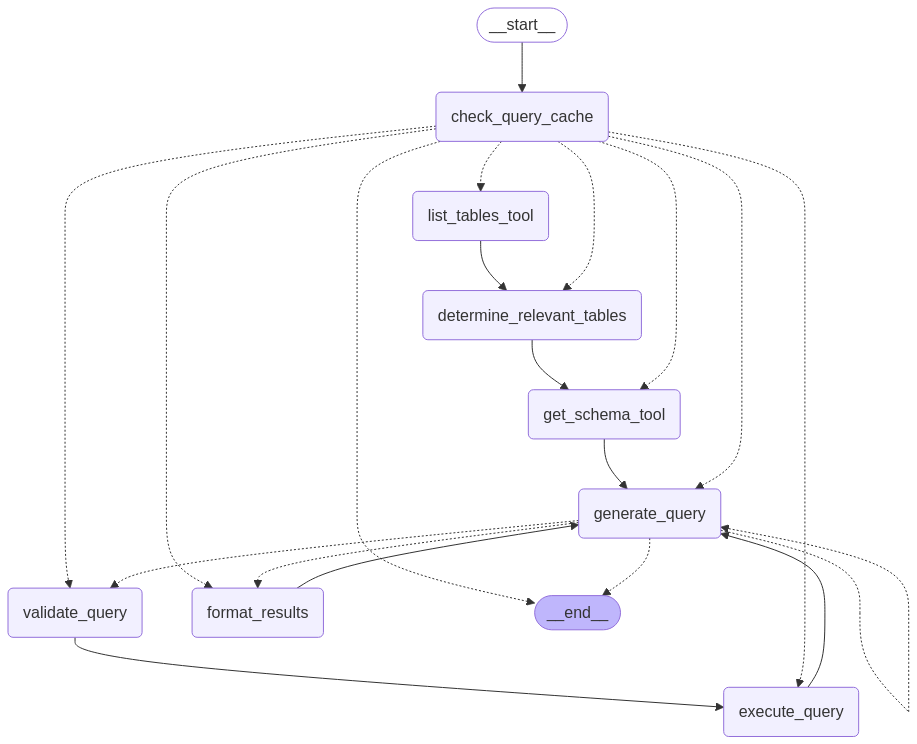

In [31]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [32]:
# Test the agent
result = agent.invoke(
    {"messages": [("user", "Which sales agent made the most in sales in 2009?")],
     "cache_info": {"hits": 0, "misses": 0}}
)
print(result["messages"][-1].tool_calls[0]["args"]["answer"])

The database schema does not provide a direct link between sales agents and invoices. Typically, this would be done through a foreign key relationship between the `Employee` and `Invoice` tables, but such a relationship is not present in the schema provided.

Without this relationship, it is not possible to determine which sales agent made the most in sales in 2009 using the current database structure. Additional information or a different schema setup would be required to answer this question accurately.


In [33]:
# Stream mode example
for event in agent.stream(
    {"messages": [("user", "List the top 5 best-selling albums.")],
     "cache_info": {"hits": 0, "misses": 0}}
):
    print(event)

{'check_query_cache': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='372df96c-943a-4848-85b5-d88d67ec16f9', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_tables_listing', 'type': 'tool_call'}])]}}
{'list_tables_tool': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='2dbc1faf-7e03-412a-8401-9f7fb833a399', tool_call_id='tool_tables_listing')]}}
{'determine_relevant_tables': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ou1nNHMsXfyD9n00U0fmkbWa', 'function': {'arguments': '{"table_names":"Album, InvoiceLine"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 173, 'total_tokens': 193, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_toke

# Evalutation on the WikiSQL dataset

In [38]:
import json
# Evaluation function
def evaluate_agent_response(example: dict):
    """Evaluation helper for answer assessment"""
    query = {"messages": ("user", example["input"]), "cache_info": {"hits": 0, "misses": 0}}
    response = agent.invoke(query)
    answer = response["messages"][-1].tool_calls[0]["args"]["answer"]
    return {"response": answer}

In [44]:
!git clone https://github.com/salesforce/WikiSQL

Cloning into 'WikiSQL'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 386 (delta 185), reused 154 (delta 154), pack-reused 194 (from 1)
Receiving objects: 100% (386/386), 50.72 MiB | 59.02 MiB/s, done.
Resolving deltas: 100% (212/212), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
tar (child): data.tar.bz2: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [45]:
!tar xvjf /kaggle/working/WikiSQL/data.tar.bz2

data/
data/train.jsonl
data/test.tables.jsonl
data/test.db
data/dev.tables.jsonl
data/dev.db
data/test.jsonl
data/train.tables.jsonl
data/train.db
data/dev.jsonl


In [46]:
!pip install -r /kaggle/working/WikiSQL/requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=029ccdaf6619f49049e5d44cdc20bdba18a7799f640fc47718b193fb2b4af83c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
